In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import roc_curve, roc_auc_score, auc

In [2]:
from sklearn.metrics import classification_report, f1_score, confusion_matrix
from xgboost import XGBClassifier
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from imblearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from collections import Counter
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.utils import class_weight

In [3]:
df = pd.read_csv('creditcard.csv')

In [4]:
# The dataframe is extremely clean, no null values, everything has been scaled to the normal distribution (-3,3) 
# except for two columns, which we might want to check scaling.
# As with all the fraud/no_fraud problems the target class is extremely unballanced which we also want to resolve.

In [5]:
df['Class'].value_counts()

0    284315
1       492
Name: Class, dtype: int64

In [6]:
X = df.drop('Class', axis=1)
y = df['Class']

In [7]:
# approximately 1 out of 500 is fraud, a metric we want to remember because we have to scale our classifier with that
counter = Counter(y)
# estimate scale_pos_weight value
estimate = counter[0] / counter[1]
print('Scale_pos_weight estimate: %.3f' % estimate)

Scale_pos_weight estimate: 577.876


In [8]:
# an equally important step in imballanced class problems is to stratify at the split level
# this ensures that the percentage of the classes is the same in both train and test sets
# which reduces the bias on both sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1, stratify=y)

In [9]:
# Finally, feature selection was done because on average we got (1-2)% better recall without it
# Despite its computational cost the classifier was the XGBc classifier.
# A scale_pos_weight of 577 was chosen because 1/577 is a fraud 
clf = Pipeline(steps = [('feature_selection',SelectKBest(mutual_info_classif)),
                   ('classifier',XGBClassifier(scale_pos_weight=577))]
)

In [10]:
clf.fit(X_train, y_train)

Pipeline(steps=[('feature_selection',
                 SelectKBest(score_func=<function mutual_info_classif at 0x000001F3ACE27550>)),
                ('classifier',
                 XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               gamma=0, gpu_id=-1, grow_policy='depthwise',
                               importance_type=None, interaction_constraints='',
                               learning_rate=0.300000012, max_bin=256,
                               max_cat_to_onehot=4, max_delta_step=0,
                               max_depth=6, max_leaves=0, min_child_weight=1,
                               missing=nan, monotone_constraints='()',
                               n_estimators=100, n_jobs=0, num_parallel_tree=1,
                               predictor='auto', random_state=0, reg_alpha=0,
                               reg_lambda=1, ...))])

In [11]:
predictions = clf.predict(X_test)

In [12]:
print(classification_report(y_test,predictions))
print('\n')
print(confusion_matrix(y_test,predictions))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.89      0.89      0.89        98

    accuracy                           1.00     56962
   macro avg       0.94      0.94      0.94     56962
weighted avg       1.00      1.00      1.00     56962



[[56853    11]
 [   11    87]]


In [13]:
round(f1_score(y_test,predictions),2)

0.89

In [14]:
round(roc_auc_score(y_test,predictions),2)

0.94

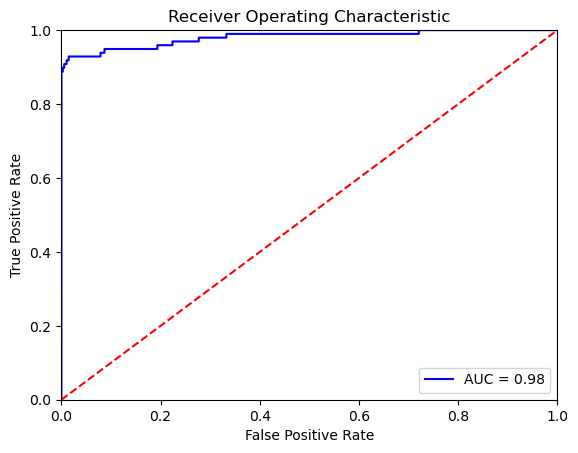

In [15]:
probs = clf.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = roc_curve(y_test, preds)
roc_auc = auc(fpr, tpr)

import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## Not bad, but we have let 11 fraudulent transactions slip under the radar.
### Lets try a gridsearch with different scale_pos_weights with f1_score scoring
### before trying to rectify the imballances with some other way

In [16]:
param_grid = {
    'classifier__scale_pos_weight': [99,250,600]
}

In [17]:
cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=2, random_state=1)

In [18]:
grid = GridSearchCV(clf, param_grid= param_grid, cv= cv, scoring='f1', verbose=1)

In [19]:
grid_result = grid.fit(X_train,y_train)

Fitting 6 folds for each of 3 candidates, totalling 18 fits


In [20]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
# report all configurations
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.836450 using {'classifier__scale_pos_weight': 250}
0.832909 (0.023638) with: {'classifier__scale_pos_weight': 99}
0.836450 (0.023297) with: {'classifier__scale_pos_weight': 250}
0.831457 (0.023770) with: {'classifier__scale_pos_weight': 600}


In [21]:
# We see that the best estimator is the one with scale_pos_weight 250 by a very thin margin
# bu after seeing the classification report we dont see any differences so we keep it at 577

In [22]:
grid_result.best_estimator_.fit(X_train,y_train)

Pipeline(steps=[('feature_selection',
                 SelectKBest(score_func=<function mutual_info_classif at 0x000001F3ACE27550>)),
                ('classifier',
                 XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               gamma=0, gpu_id=-1, grow_policy='depthwise',
                               importance_type=None, interaction_constraints='',
                               learning_rate=0.300000012, max_bin=256,
                               max_cat_to_onehot=4, max_delta_step=0,
                               max_depth=6, max_leaves=0, min_child_weight=1,
                               missing=nan, monotone_constraints='()',
                               n_estimators=100, n_jobs=0, num_parallel_tree=1,
                               predictor='auto', random_state=0, reg_alpha=0,
                               reg_lambda=1, ...))])

In [23]:
predictions = grid_result.best_estimator_.predict(X_test)
print(classification_report(y_test,predictions))
print('\n')
print(confusion_matrix(y_test,predictions))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.89      0.89      0.89        98

    accuracy                           1.00     56962
   macro avg       0.94      0.94      0.94     56962
weighted avg       1.00      1.00      1.00     56962



[[56853    11]
 [   11    87]]


## Computing class weight from sklearn.utils

In [24]:
k_train = class_weight.compute_class_weight('balanced', classes= np.unique(y_train), y= y_train)
wt = dict(zip(np.unique(y_train), k_train))

# Map class weights to corresponding target class values, make sure class labels have range (0, n_classes-1)
w_array = y_train.map(wt)
set(zip(y_train,w_array))

# Convert wt series to wt array
w_array = w_array.values

# Define new pipeline
clf1 = Pipeline(steps = [('feature_selection',SelectKBest(mutual_info_classif)),
                   ('classifier',XGBClassifier())]
)

#Apply wt array to .fit()
clf1.fit(X_train, y_train, classifier__sample_weight=w_array)

Pipeline(steps=[('feature_selection',
                 SelectKBest(score_func=<function mutual_info_classif at 0x000001F3ACE27550>)),
                ('classifier',
                 XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               gamma=0, gpu_id=-1, grow_policy='depthwise',
                               importance_type=None, interaction_constraints='',
                               learning_rate=0.300000012, max_bin=256,
                               max_cat_to_onehot=4, max_delta_step=0,
                               max_depth=6, max_leaves=0, min_child_weight=1,
                               missing=nan, monotone_constraints='()',
                               n_estimators=100, n_jobs=0, num_parallel_tree=1,
                               predictor='auto', random_state=0, reg_alpha=0,
                               reg_lambda=1, ...))])

In [25]:
predictions1 = clf1.predict(X_test)

In [26]:
print(classification_report(y_test,predictions1))
print('\n')
print(confusion_matrix(y_test,predictions1))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.89      0.89      0.89        98

    accuracy                           1.00     56962
   macro avg       0.94      0.94      0.94     56962
weighted avg       1.00      1.00      1.00     56962



[[56853    11]
 [   11    87]]


### We arrive at the same results

# Closing arguments:

## A model with a sufficient auc score and recall score was produced.
## Only 2.2% of frauds were undetected
## General strategy: Lower minority precision to achieve better minority recall (trade-off)
## because labeling non frauds as frauds is better than to miss frauds